In [28]:
import numpy as np
import cvxopt
import matplotlib.pyplot as plt
from sklearn import svm
import pandas as pd

# Soft margin SVM
this part we are going to implement soft margin svm. We're using cvxopt library to solve quadratic equations in support vector machines.

## formulas and equations
First we will speak of the CVXOPT library. in this library to solve a quadratic equation, equations must be in the form as equation \ref{eq:quadratic-cvxopt-form}
\begin{equation} 
\begin{aligned}
&min \: \frac{1}{2} x^T P x + q^Tx \\
&subject \; to \; Gx \leq h \\
& Ax=b
\end{aligned}
\label{eq:quadratic-cvxopt-form}
\end{equation}

And the dual problem equations in support vector machines are as
\begin{equation} \label{eq:dual-problem-expression}
max \sum_{i=1}^{m} \alpha_i - \frac{1}{2} \sum_{i,j=1}^{m} y_i y_j \alpha_i \alpha_j x_{i}^{T} x_j
\end{equation}
And if we write $H$ as $H_{i,j} = y_i y_j x_{i}^{T} x_j$
the optimazation equation will be as 
\begin{equation}
\begin{aligned}
&max \: \sum_{i=1}^{m} \alpha_i - \frac{1}{2} \alpha^T H \alpha \\
& subject \; to \; 0 \leq \alpha_i \leq C \\
& \sum_{i}^{m} \alpha_i y_i = 0
\end{aligned}
\end{equation}
Note that $H$ will be our gram matrix. and if we want to convert our problem to the notation of CVXOPT library we can write

 $P$ stands for H with the shape $m \times m$, $q$ stands for -1 vector with shape of $m \times 1$, $G$ stands for a digonal matrix with -1 on the diagonal and the shape of $m \times m$, $h$ stands for a zero vector with the shape of $m \times 1$, $A$ stands for the label vector y with the shape of $m \times 1$ and $b$ is a scalar.

To convert the maximum problem into minimum we can multilpy all equations with a $-1$ 
\begin{equation}
\begin{aligned}
& min \: \frac{1}{2} \alpha^T H \alpha - 1^T \alpha_i \\
& subject \; to \; \alpha_i \leq C \\
&  -\alpha_i \leq 0 \\
& \sum_{i}^{m} \alpha_i y_i = 0
\end{aligned}
\end{equation}
also we can rewrite the last equation as below, meaning all lables ($y$) are in one vector
\begin{equation}
y^T \alpha = 0
\end{equation}

## implementation
Now we're going to implement soft margin svm with an example.  The data are as follows
\begin{equation}
X =
\begin{pmatrix}
3 & 1 & 2 & 6 & 7 & 5 & 2 \\
4 & 4 & 3 & -1 & -1 & -3 & 4
\end{pmatrix}
\end{equation}
And the labels are 
\begin{equation}
Y = 
\begin{pmatrix}
-1 & -1 & -1 & 1 & 1 & 1 & 1 \\
\end{pmatrix}
\end{equation}
because the dimension of samples are 2 and we have two constraints $G$ and $h$, we can write these constraints as 
\begin{equation}
G = 
\begin{pmatrix}
-1 & 0 \\
0 & -1 \\
1 & 0 \\
0 & 1
\end{pmatrix}
\end{equation}

\begin{equation}
h = 
\begin{pmatrix}
0 \\
0 \\
C \\
C
\end{pmatrix}
\end{equation}

In [2]:
def svm_soft_margin(X, y, C):
    """
    implementation of soft margin svm
    we didn't use a kernel function we just made a linear inner product of data
    
    INPUTS:
    --------
    X: the numpy matrix of input vectors, shape is m*n meaning m is the dimension and n is data sample size
    y: numpy vector of labels, shape is n*1
    
    """
    
    m,n = X.shape
    
    ## multiplying the labels with inputs
    X_dash = y * X

    ############### LINEAR product ###############
    ## inner product 
    ## with this the labels will be multiplied twice as in the dual problem equation
    H = np.dot(X_dash, X_dash.T)
    
    ## convert data into cvxopt format
    P = cvxopt.matrix(H)
    q = cvxopt.matrix(-np.ones(m))
    G = cvxopt.matrix(np.vstack((np.eye(m)*-1,np.eye(m))))
    h = cvxopt.matrix(np.hstack((np.zeros(m), np.ones(m) * C)))
    A = cvxopt.matrix(y.reshape(1, -1))
    b = cvxopt.matrix(np.zeros(1))

    ## solve the qaudratic equations
    answer = cvxopt.solvers.qp(P, q, G, h, A, b)

    ## the lagrangian coefficients (named as alpha)
    alphas = np.array(answer['x'])

    ## computing parameters of the line equation
    w = ((y * alphas).T @ X).reshape(-1,1)
    S = (alphas > 1e-4).flatten()
    b = y[S] - np.dot(X[S], w)

    #Display results
    print('Alphas = ',alphas[alphas > 1e-4])
    print('w = ', w.flatten())
    print('b = ', b[0])


In [3]:
## dataset
X = np.array([[3,4],[1,4],[2,3],[6,-1],[7,-1],[5,-3],[2,4]], dtype=float)
y = np.array([-1,-1, -1, 1, 1 , 1, 1 ], dtype=float)

## define C 
C = 10

y = y.reshape(-1,1)
svm_soft_margin(X, y, C)

     pcost       dcost       gap    pres   dres
 0: -1.5556e+01 -2.5999e+02  3e+02  1e-01  2e-14
 1: -1.8050e+01 -3.9497e+01  2e+01  4e-03  1e-14
 2: -2.1437e+01 -2.3412e+01  2e+00  3e-04  2e-14
 3: -2.2496e+01 -2.2997e+01  5e-01  3e-05  1e-14
 4: -2.2561e+01 -2.2568e+01  6e-03  3e-07  2e-14
 5: -2.2562e+01 -2.2563e+01  6e-05  3e-09  2e-14
 6: -2.2562e+01 -2.2563e+01  6e-07  3e-11  1e-14
Optimal solution found.
Alphas =  [4.9999998  6.31250013 1.31249982 9.99999997]
w =  [ 0.25000001 -0.25000001]
b =  [-0.74999997]


# Twin Support Vector Machine (TWSVM)
In this type of svm called twin support vector machines we are going to have to non-parallel lines. This is a binary classifier as SVM and to classify each data we need to find out that the data point is close to which of the hyperplains. <br>
To demonstrate the equation for this type of svm we can write them as below.
\begin{align*}
w_1^T x+b_1&=0          &  w_2^Tx+b_2&=0
\end{align*}
And we need to solve quadratic equations as below
\begin{equation}
min \; \frac{1}{2} (Aw_1 + e_1 b_1)^T(Aw_1 + e_1 b_1) + c_1 e_2^T \xi_2 \\
subject \; to \; -(Bw_1 + e_2 b_1) + \xi_2 \geq e_2 \\
\xi_2 \geq 0
\end{equation}
and for the second line
\begin{equation}
min \; \frac{1}{2} (Bw_2 + e_2 b_2)^T(Bw_2 + e_2 b_2) + c_2 e_1^T \xi_1 \\
subject \; to \; Aw_2 + e_1 b_2 + \xi_1 \geq e_1 \\
\xi_1 \geq 0
\end{equation}

If we go and calculate them we using wolfe dual method, can find the answers as below
\begin{equation}
max \; e_2^T \alpha - \frac{1}{2} \alpha^T G(H^TH)^{-1} G^T \alpha \\
subject \; to \; 0 \leq \alpha \leq c_1
\end{equation}
and for the second line 
\begin{equation}
max \; e_1^T \beta - \frac{1}{2} \beta^T H(G^TG)^{-1} H^T \beta \\
subject \; to \; 0 \leq \beta \leq c_2
\end{equation}
while $G=[A \;\; e_1]$, $H=[B \;\; e_2]$, $e_1$ and $e_2$ are the column vector of one with the right dimension(data dimension). Also the lagrange coefficients are $\alpha$ and $\beta$.

And to find the weight and bias of the hyperplains, we can derive it from equations below
\begin{align*}
v_1&=-(H^TH)^{-1}G^T\alpha      &    where \;\;\; v_1&=[w_1 \;\; b_1]^T \\
v_2&=-(G^TG)^{-1}H^T\beta      &    where \;\;\; v_2&=[w_2 \;\; b_2]^T
\end{align*}


And to find the class for each data we can use the equation below to find the closest hyperplain for a data
\begin{equation}
Class \;\; K = argmin_{k=1,2} \frac{|w_k^Tx+b_k|}{||w_k||}
\end{equation}

## implementation
We set $m=2$, meaning the dimension of data is two. then we can derive $G$ and $h$ matrices for lagrangian coefficients are as below
\begin{equation}
G_1 = 
\begin{pmatrix}
-1 & 0 \\
0 & -1 \\
1 & 0 \\
0 & 1
\end{pmatrix}
\end{equation}

\begin{equation}
h_1 = 
\begin{pmatrix}
0 \\
0 \\
c_1 \\
c_2
\end{pmatrix}
\end{equation}
Also $h_2$ and $G_2$ are the same.

In [104]:
c1 = 10
c2 = 10

data_A = np.array([[3,4],[1.5,4],[2,3],[6,-1],[7,-1],[5,-3],[2,4]], dtype=float)
y1 = np.array([1,1, 1, 1, 1 , 1, 1], dtype=float)

data_A = np.array([[1,1], [1,0], [0,1]])
y1 = np.array([1, 1, 1], dtype=float)
y1 = y1.reshape(-1,1)

y1 = np.concatenate((y1, [[1]]))

data_B = np.array([[-1, 5], [-2, 6], [-3, 8], [-1.5, 5], [0, 2], [0, -2], [-1, -3]], dtype=float)
y2 = np.array([-1,-1, -1, -1, -1 , -1, -1], dtype=float)
# data_B = np.array([[0,0], [-1, -1], [-1, 0]])
# y2 = np.array([-1, -1, -1], dtype= float)
y2 = y2.reshape(-1,1)

y2 = np.concatenate((y2, [[-1]]))

m1, n1 = data_A.shape
m2, n2 = data_B.shape
m2 += 1
m1 += 1

e1 = np.ones(n1, dtype=float)
e2 = np.ones(n2, dtype=float)

## y1 and y2 are the labels and must be multiplied
G =  y1 * np.concatenate(( data_A , [e1]), axis=0)
H = y2 * np.concatenate((data_B , [e2]), axis=0)

## for each hyperplain
## the equations shows the maximum, in order to find the minimum a -1 is multiplied to each equation
P1 = -1* G.dot(np.linalg.inv(np.dot(H.T, H))).dot(G.T)
P2 = -1* H.dot(np.linalg.inv(np.dot(G.T, G))).dot(H.T)

## convert to cvxopt matrix
P1 = cvxopt.matrix(P1)
P2 = cvxopt.matrix(P2)

q1 = cvxopt.matrix(-np.ones(m1))
q2 = cvxopt.matrix(-np.ones(m2))

G1 = cvxopt.matrix(np.vstack((np.eye(m1)*-1,np.eye(m1))))
h1 = cvxopt.matrix(np.hstack((np.zeros(m1), np.ones(m1) * c1)))

G2 = cvxopt.matrix(np.vstack((np.eye(m2)*-1,np.eye(m2))))
h2 = cvxopt.matrix(np.hstack((np.zeros(m2), np.ones(m2) * c2)))

## the other constraints

A1 = cvxopt.matrix(y1.reshape(1, -1))
b1 = cvxopt.matrix(np.zeros(1))

A2 = cvxopt.matrix(y2.reshape(1, -1))
b2 = cvxopt.matrix(np.zeros(1))

answer1 = cvxopt.solvers.qp(P1, q1, G1, h1, A1, b1)
# answer2 = cvxopt.solvers.qp(P2, q2, G2, h2, A2, b2)


## the lagrangian coefficients (named as alpha)
alphas1 = np.array(answer1['x'])

v1 = -1 * np.linalg.inv((G.T @ G)).dot(H.T) * alphas1
v1

# ## computing parameters of the line equation
# w1 = ((y1 * alphas).T @ G).reshape(-1,1)
# S1 = (alphas > 1e-4).flatten()
# b1 = y1[S1] - np.dot(G, w1)

# print("Answer 1")
# print('Alphas = ',alphas[alphas > 1e-4])
# print('w1 = ', w.flatten())
# print('b1 = ', b[0])

     pcost       dcost       gap    pres   dres
 0: -1.3407e-15 -4.0000e+01  9e+01  1e-01  2e-15
 1:  6.3531e-17 -7.3007e-01  1e+00  1e-03  2e-15
 2:  6.2971e-19 -7.3014e-03  1e-02  1e-05  3e-15
 3:  6.2978e-21 -7.3014e-05  1e-04  1e-07  2e-15
 4:  6.2978e-23 -7.3014e-07  1e-06  1e-09  2e-15
 5:  6.2978e-25 -7.3014e-09  1e-08  1e-11  3e-15
Optimal solution found.


ValueError: operands could not be broadcast together with shapes (2,8) (4,1) 

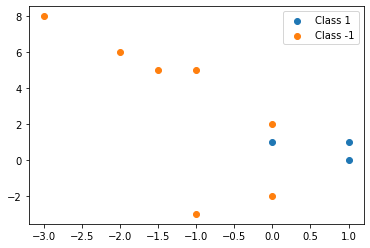

In [105]:
plt.scatter(data_A[:,0], data_A[:,1])
plt.scatter(data_B[:,0], data_B[:,1])
plt.legend(['Class 1', 'Class -1'])
plt.show()

In [107]:
# np.concatenate((data_A, [e1])) 
H

array([[ 1. , -5. ],
       [ 2. , -6. ],
       [ 3. , -8. ],
       [ 1.5, -5. ],
       [-0. , -2. ],
       [-0. ,  2. ],
       [ 1. ,  3. ],
       [-1. , -1. ]])

# K-SVCR
The main concept of K-SVCR proposed by Cecilio Angulo and Andreu Catala in 2003 was to classify more than two classses and it uses the idea of one-vs-one-vs-rest. The difference between this method and the one-vs-one or one-vs-rest is, it will use three classes in each step of support vector evaluation. First it calculates a support vector for class label $+1$, then it calculates another one for label $-1$ and at last for other classes it apply label $0$ for other classes. <br>
The equation below would help to better understand this method.(Note that $N$ is the count of our data) 
\begin{equation}
  f(x_p) =
    \begin{cases}
      1 & \text{if $p=1,\; 2, ..., n$}\\
      -1 & \text{if $p=n+1, \; n+2, ..., n+m$}\\
      0 & \text{if $p=n+m+1, \; n+m+2, ..., N$}
    \end{cases}       
\end{equation}
And the equations for the optimization problem will be
\begin{equation}
arg \: min \; \frac{1}{2} ||w||^2
\end{equation}
With the equation above we are maximazing the margin of each decesion boundary.